In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

plt.style.use('seaborn-white')

In [797]:
# Golden Ratio
gr = (np.sqrt(5.0) + 1.0) / 2.0
# Golden Angle
ga = (2.0 - gr) * (2.0*np.pi)

dist = 100
observer = [0, 0, dist]


def get_sun(incl=45, orbital_phase_angle_around_sun=90):
    if not hasattr(incl, '__iter__'):
        incl = [incl]
    if not hasattr(orbital_phase_angle_around_sun, '__iter__'):
        orbital_phase_angle_around_sun = [orbital_phase_angle_around_sun]
    incl = np.asarray(incl)
    orbital_phase_angle_around_sun = np.asarray(orbital_phase_angle_around_sun)
    sun_vec = [np.sin(np.deg2rad(incl)) * dist * np.sin(np.deg2rad(orbital_phase_angle_around_sun)),
           np.cos(np.deg2rad(incl)) * dist * np.sin(np.deg2rad(orbital_phase_angle_around_sun)),
           np.cos(np.deg2rad(orbital_phase_angle_around_sun)) * dist * incl**0]
    
    return np.asarray(sun_vec)


class Body():
    def __init__(self, r=[1, 1, 1], center_of_mass=[0, 0, 0], rotation_axis=[1, 0, 0], num_points=5000):
        self.r = r
        self.rotation_axis = np.asarray(rotation_axis, float)
        self.rotation_axis /= np.sum(np.asarray(self.rotation_axis)**2)**0.5
        self.center_of_mass = center_of_mass
        lat = np.arcsin(-1 + (2*np.arange(num_points)/(num_points + 1)))
        lon = ga * np.arange(num_points)
        
        x = r[0]*np.cos(lon)*np.cos(lat) + center_of_mass[0]
        y = r[1]*np.sin(lon)*np.cos(lat) + center_of_mass[1]
        z = r[2]*np.sin(lat) + center_of_mass[2]

        self.vec = np.vstack([x, y, z]).T
        self.vec_p = np.copy(self.vec)
        self.sun = get_sun()
        self.update_sun()
        self.update()
        
        
    def update_sun(self, incl=45, orbital_phase_angle_around_sun=90):
        self.sun = get_sun(incl, orbital_phase_angle_around_sun)    
    
    def update(self, theta=0):
        if not hasattr(theta, '__iter__'):
            theta = [theta]
#        self.vec_p = R.from_rotvec(angle * np.asarray(self.rotation_axis, dtype=np.float64)).apply(self.vec)
        vec_p = []
        for angle in theta:
            vec_p.append(R.from_rotvec(angle * np.asarray(b.rotation_axis, dtype=np.float64)).apply(b.vec))
        self.vec_p = np.asarray(vec_p).transpose([1, 0, 2])
        if self.vec_p.shape[1] != self.sun.shape[1]:
            if self.vec_p.shape[1] == 1:
                self.vec_p = self.vec_p * np.ones((self.vec_p.shape[0], self.sun.shape[1], self.vec_p.shape[2]))
            elif self.sun.shape[1] == 1:
                self.sun = self.sun * np.ones((3, self.vec_p.shape[1]))
            else:
                raise ValueError('help')
            
#    I = vec_p.dot(np.asarray(np.asarray(sun)/dist)[:, None])
    #    I[I < 0] = 0
        n = np.atleast_2d(np.sum(self.vec_p**2, axis=2)) * np.atleast_2d((np.asarray(self.sun)**2).sum(axis=0))
        I = np.asarray([self.vec_p[:, idx, :].dot(self.sun[:, idx]) for idx in range(self.sun.shape[1])]).T
        I[I < 0] = 0
        observable = np.asarray([(self.vec_p[:, idx, :].dot(np.asarray(observer)[:, None]) >=0)[:, 0] for idx in range(self.vec_p.shape[1])]).T
        I[~observable] = 0
        self.I = I
        self.f = I.sum(axis=0)#/observable.sum()  
        
    def flux(self, theta):
        if not hasattr(theta, '__iter__'):
            theta = [theta]
        f = np.zeros_like(theta)
        for idx, a in enumerate(theta):
            self.update(theta=a)
            f[idx] = self.f  
        return f
    
    def plot_phase_curve(self, ax=None, **kwargs):
        angle = np.linspace(-2*np.pi, 2*np.pi, 200)
        f = self.flux(angle)  
        if ax is None:
            fig, ax = plt.subplots(facecolor='w')
        plt.plot(angle, f, **kwargs)
        plt.xlabel('Phase')
        plt.ylabel('Flux')
        return ax
        
    def plot_object(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        ax.set_facecolor('k')
        observable = self.I[:, 0] != 0        
        scat = ax.scatter(self.vec_p[:, 0, 1][observable], self.vec_p[:, 0, 0][observable], s=10, c=self.I[:, 0][observable], cmap='Greys_r', vmin=0, vmax=100)
        ax.set(xlim=(-np.max(self.r + np.abs(self.center_of_mass))*1.2, np.max(self.r + np.abs(self.center_of_mass))*1.2), 
               ylim=(-np.max(self.r + np.abs(self.center_of_mass))*1.2, np.max(self.r + np.abs(self.center_of_mass))*1.2), 
               xticklabels=[], yticklabels=[])
        plt.gca().set_position([0, 0, 1, 1])
        return fig
    
    def animate_object(self, theta=None, file=None):
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.set_facecolor('k')
        if theta is None:
            theta = np.linspace(-2*np.pi, 2*np.pi, 100)
        self.update(theta)
        observable = self.I[:, 0] != 0
        
        scat = ax.scatter(self.vec_p[:, 0, 1][observable], self.vec_p[:, 0, 0][observable], s=10, c=self.I[:, 0][observable], cmap='Greys_r', vmin=0, vmax=100)
        ax.set(xlim=(-np.max(self.r + np.abs(self.center_of_mass))*1.2, np.max(self.r + np.abs(self.center_of_mass))*1.2), 
               ylim=(-np.max(self.r + np.abs(self.center_of_mass))*1.2, np.max(self.r + np.abs(self.center_of_mass))*1.2), 
               xticklabels=[], yticklabels=[])
        plt.gca().set_position([0, 0, 1, 1])

        if not hasattr(theta, '__iter__'):
            nframes = self.sun.shape[1]
        else:
            nframes = len(theta)
            
        def update_anim(i):
            """Update the scatter plot."""
            observable = self.I[:, i] != 0
            # Set x and y data...
            scat.set_offsets(np.vstack([self.vec_p[:, i, 1][observable], self.vec_p[:, i, 0][observable]]).T)
            # Set colors..
            scat.set_array(self.I[:, i][observable])

            # We need to return the updated artist for FuncAnimation to draw..
            # Note that it expects a sequence of artists, thus the trailing comma.
            return scat,
        anim = animation.FuncAnimation(fig, update_anim, frames=nframes, blit=True, interval=75)
        if file is not None:
            if file.endswith(".mp4"):
                    anim.save(file, writer="ffmpeg", dpi=100)
            elif file.endswith(".gif"):
                anim.save(
                    file, writer="imagemagick", dpi=100
                )
            else:
                raise ValueError('filename not recognized')
        display(HTML(anim.to_html5_video()))
        plt.close()

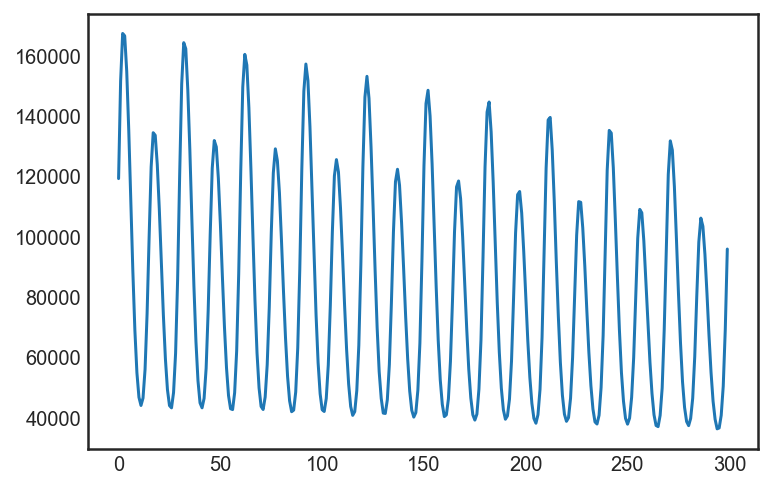

In [820]:
# Angle to the sun as a function of time
op = np.linspace(85, 95, 300)

# Inclination to the sun as a function of time
incl = np.linspace(40, 50, 300)

# Body rotation angle as a function of time
theta = np.linspace(0, 20*np.pi, 300)

b = Body(r=[1, 2, 1],
        center_of_mass=[0, 0.1, 0], 
        rotation_axis=[1, 0, 0])


b.update_sun(incl, op)
b.update(theta)
plt.plot(b.f)

In [821]:
b.animate_object(theta=theta)

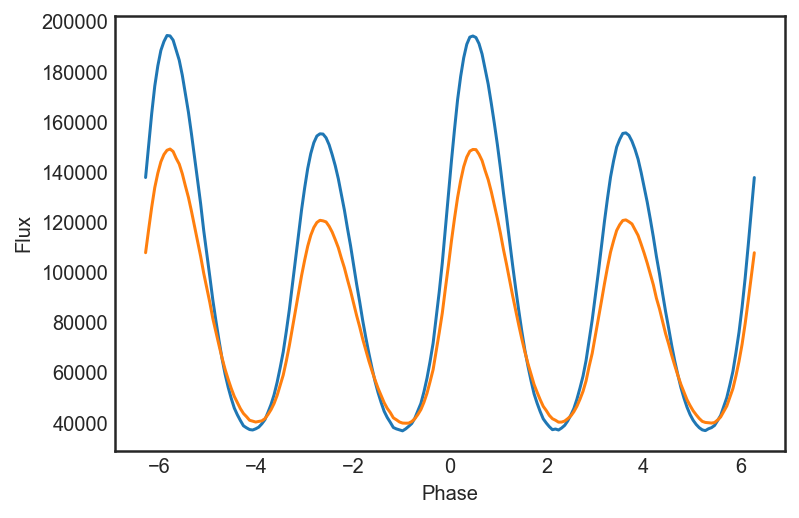

In [822]:
b.update_sun(0)
ax = b.plot_phase_curve();
f1 = b.flux(np.linspace(-np.pi, np.pi, 100))
b.update_sun(45)
b.plot_phase_curve(ax=ax);
f2 = b.flux(np.linspace(-np.pi, np.pi, 100))